In [4]:
import warnings
warnings.simplefilter("ignore")
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LeakyReLU, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization
from tensorflow import keras
from tensorflow.keras.initializers import TruncatedNormal
tf.keras.backend.set_floatx('float32')

In [3]:
def generator(z, output_channel_dim):
        model = Sequential()
        # 8x8x1024
        model.add(Dense(8*8*1024, input_shape=z.shape))
        model.add(Reshape((8, 8, 1024)))
        model.add(LeakyReLU())
        
        # 8x8x1024 -> 16x16x512
        model.add(Conv2DTranspose(filters=512, kernel_size=(5, 5), strides= (2, 2), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
        model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
        model.add(LeakyReLU())

        # 16x16x512 -> 32x32x256
        model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides= (2, 2), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
        model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
        model.add(LeakyReLU())  
      
        # 32x32x256 -> 64x64x128
        model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides= (2, 2), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
        model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
        model.add(LeakyReLU())          
        
        # 64x64x128 -> 64x64x64
        model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides= (1, 1), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
        model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
        model.add(LeakyReLU())                    
                  
        
        # 64x64x64 -> 64x64x3
        model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5), strides= (1, 1), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
        model.add(Activation(activation='tanh'))        
                  
        out=model(z)
        return out

In [5]:
def discriminator(x):
   # 64*64*3 -> 64x64x64     
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides= (1, 1), padding='same', 
                          kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV), 
                              input_shape=(64,64,3)))
              
    model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
    model.add(LeakyReLU())


    # 64x64x64-> 32x32x128 
    model.add(Conv2D(filters=128, kernel_size=(5, 5), strides= (2, 2), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))          
    model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
    model.add(LeakyReLU())        
                
    # 32x32x128 -> 16x16x256  
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides= (2, 2), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))          
    model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
    model.add(LeakyReLU())      
        
    # 16x16x256 -> 16x16x512
    model.add(Conv2D(filters=512, kernel_size=(5, 5), strides= (1, 1), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))          
    model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
    model.add(LeakyReLU())      
     
    # 16x16x512 -> 8x8x1024
    model.add(Conv2D(filters=1024, kernel_size=(5, 5), strides= (2, 2), padding='same', 
                          kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))          
    model.add(BatchNormalization(epsilon=EPSILON, trainable= True))
    model.add(LeakyReLU())       
    
    model.add(Flatten())
    model.add(Reshape((8, 8, 1024)))
    model.add(Dense(1))
    logits = model(x)
    
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                 input_shape=(64, 64, 3)))

    model.add(BatchNormalization(epsilon=EPSILON, trainable=True))
    model.add(LeakyReLU())

    # 64x64x64-> 32x32x128
    model.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(BatchNormalization(epsilon=EPSILON, trainable=True))
    model.add(LeakyReLU())

    # 32x32x128 -> 16x16x256
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(BatchNormalization(epsilon=EPSILON, trainable=True))
    model.add(LeakyReLU())

    # 16x16x256 -> 16x16x512 
    model.add(Conv2D(filters=512, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(BatchNormalization(epsilon=EPSILON, trainable=True))
    model.add(LeakyReLU())

    # 16x16x512 -> 8x8x1024
    model.add(Conv2D(filters=1024, kernel_size=(5, 5), strides=(2, 2), padding='same',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(BatchNormalization(epsilon=EPSILON, trainable=True))
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 1024)))
    model.add(Dense(1))
    model.add(Activation(activation='sigmoid'))
    out = model(x)
    return out, logits

In [6]:
def model_loss(input_real, input_z, output_channel_dim):
     

    g_model =  tf.dtypes.cast(generator(input_z, output_channel_dim), tf.float32)

    noisy_input_real =  tf.dtypes.cast(input_real + tf.random.normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32), tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real)
    d_model_fake, d_logits_fake = discriminator(g_model)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

In [7]:
def model_optimizers(d_loss, g_loss):

    t_vars = tf.compat.v1.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]

    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.keras.optimizers.Adam(learning_rate=LR_D, beta_1=BETA1).get_updates(d_loss, d_vars)
        g_train_opt = tf.keras.optimizers.Adam(learning_rate=LR_G, beta_1=BETA1).get_updates(g_loss, g_vars)  
    return d_train_opt, g_train_opt

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.Variable(tf.zeros(shape = real_dim), name='inputs_real')
    inputs_z = tf.Variable(tf.zeros(shape = z_dim), name="input_z")
    learning_rate_G = tf.Variable(tf.zeros(shape=(1)), name="lr_g")
    learning_rate_D = tf.Variable(tf.zeros(shape=(1)), name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

In [9]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [10]:
def test(input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = generator(example_z, out_channel_dim)
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)

In [11]:
def summarize_epoch(epoch, duration, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print(minibatch_size)
    print(d_losses[-minibatch_size:])
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(input_z, data_shape[3], epoch)

In [12]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

In [13]:
def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    #d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    #d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    epoch = 0
    iteration = 0
    d_losses = []
    g_losses = []
        
    for epoch in range(EPOCHS):        
        epoch += 1
        start_time = time.time()

        for batch_images in get_batches:
            batch_images=np.float32(batch_images)
            iteration += 1
            batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
            batch_z =np.float32(batch_z)
            d_loss, g_loss = model_loss(batch_images, batch_z, data_shape[3])
            d_opt, g_opt = model_optimizers(d_loss, g_loss)                                                        
            d_losses.append(d_loss.numpy())
            g_losses.append(g_loss.numpy())

        summarize_epoch(epoch, time.time()-start_time, d_losses, g_losses, input_z, data_shape)

In [14]:
# Paths
INPUT_DATA_DIR = "C:/Users/azhao/Box/2019_Study/Deep Learning/Homwwork_4 Generative Models/image_generator-master/cropped"
# Path to the folder with input images. 
#OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
#if not os.path.exists(OUTPUT_DIR):
#    os.makedirs(OUTPUT_DIR)
OUTPUT_DIR = ""

In [15]:
# Hyperparameters
IMAGE_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 5 #to save time
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 5

Input: (9877, 64, 64, 3)


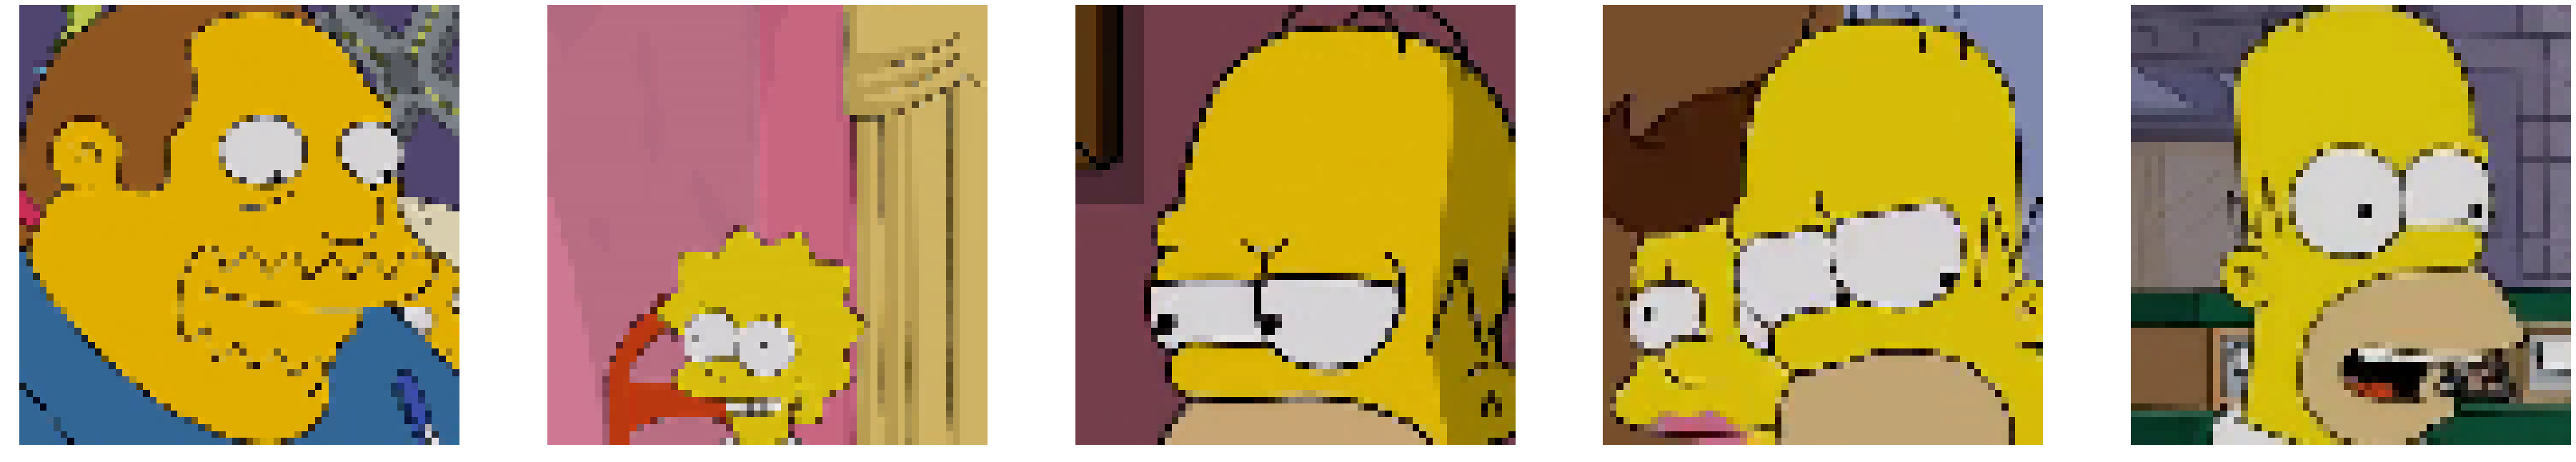

float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32
dense1
conv2d1
conv2d2
float32


In [ ]:
# Training
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))
tf.dtypes.cast(input_images, tf.float32)

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

#with tf.Graph().as_default():
train(get_batches(input_images), input_images.shape)